## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp019'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

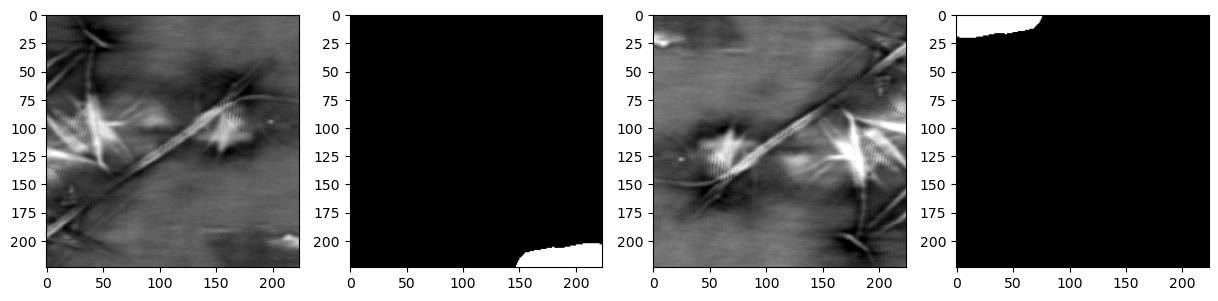

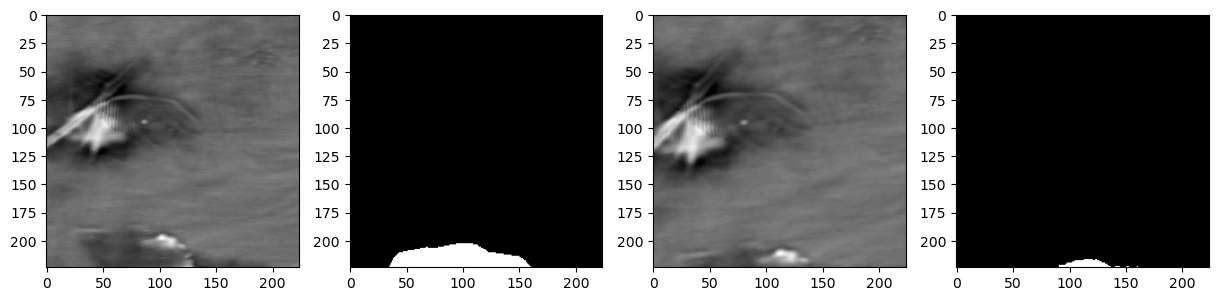

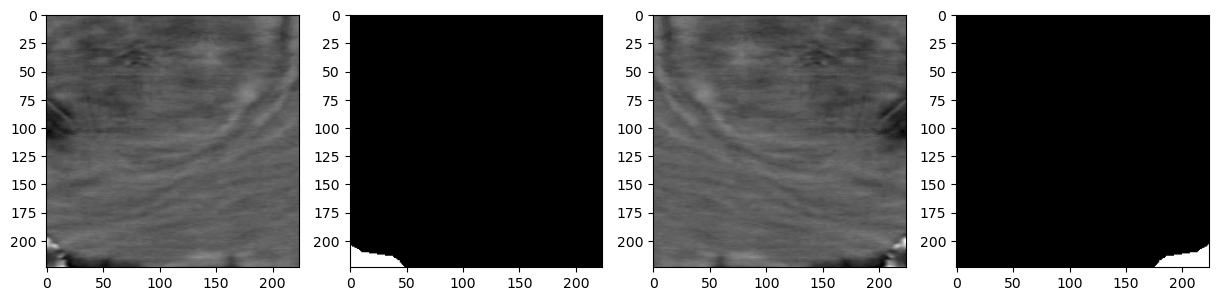

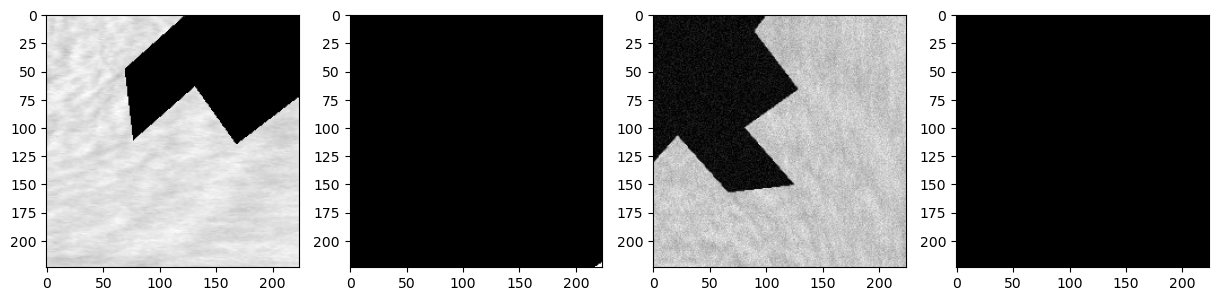

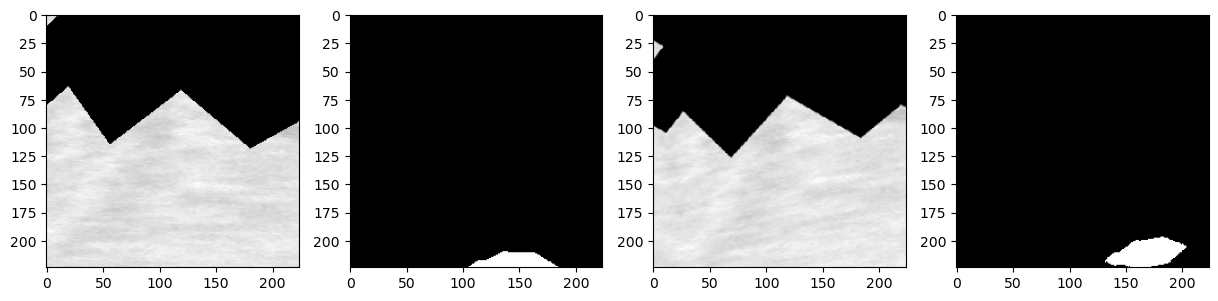

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48140

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.120966158850492
th: 0.15, fbeta: 0.12097371935959512
th: 0.2, fbeta: 0.12734579537810733
th: 0.25, fbeta: 0.22118025014944032
th: 0.3, fbeta: 0.27541811813715883
th: 0.35, fbeta: 0.32135337046177714
th: 0.4, fbeta: 0.36124626882713445
th: 0.45, fbeta: 0.38757751242309146


best_th: 0.5, fbeta: 0.3957728126802197
Epoch 1 - avg_train_loss: 0.5753  avg_val_loss: 0.3974  time: 160s
Epoch 1 - avgScore: 0.3958
Epoch 1 - Save Best Score: 0.3958 Model
Epoch 1 - Save Best Loss: 0.3974 Model


th: 0.5, fbeta: 0.3957728126802197


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12097098248774701
th: 0.15, fbeta: 0.20034407054655148
th: 0.2, fbeta: 0.2581024026769492
th: 0.25, fbeta: 0.32228622326837064
th: 0.3, fbeta: 0.35868585858195545
th: 0.35, fbeta: 0.3877016060548899
th: 0.4, fbeta: 0.4121998806912944
th: 0.45, fbeta: 0.4309164125516329


best_th: 0.5, fbeta: 0.4388457965708552
Epoch 2 - avg_train_loss: 0.3907  avg_val_loss: 0.3340  time: 165s
Epoch 2 - avgScore: 0.4388
Epoch 2 - Save Best Score: 0.4388 Model
Epoch 2 - Save Best Loss: 0.3340 Model


th: 0.5, fbeta: 0.4388457965708552


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.44730221594081215
th: 0.15, fbeta: 0.46853179972989
th: 0.2, fbeta: 0.4760553049432708
th: 0.25, fbeta: 0.47535390874081745
th: 0.3, fbeta: 0.4624140625355999
th: 0.35, fbeta: 0.4408825794835261
th: 0.4, fbeta: 0.4151838789230488
th: 0.45, fbeta: 0.3806949137884738


best_th: 0.2, fbeta: 0.4760553049432708
Epoch 3 - avg_train_loss: 0.2928  avg_val_loss: 0.2829  time: 165s
Epoch 3 - avgScore: 0.4761
Epoch 3 - Save Best Score: 0.4761 Model
Epoch 3 - Save Best Loss: 0.2829 Model


th: 0.5, fbeta: 0.32920175281880976


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32075738350710903
th: 0.15, fbeta: 0.39353524625889236
th: 0.2, fbeta: 0.440908625861582
th: 0.25, fbeta: 0.47024269425732423
th: 0.3, fbeta: 0.4941052989794796
th: 0.35, fbeta: 0.5031036190583748
th: 0.4, fbeta: 0.4997166082851527
th: 0.45, fbeta: 0.4827953190358625


best_th: 0.35, fbeta: 0.5031036190583748
Epoch 4 - avg_train_loss: 0.2521  avg_val_loss: 0.2269  time: 165s
Epoch 4 - avgScore: 0.5031
Epoch 4 - Save Best Score: 0.5031 Model
Epoch 4 - Save Best Loss: 0.2269 Model


th: 0.5, fbeta: 0.44883372786897413


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3144362564297602
th: 0.15, fbeta: 0.3341495606652184
th: 0.2, fbeta: 0.3519253068347767
th: 0.25, fbeta: 0.36939797210060726
th: 0.3, fbeta: 0.38691733241031345
th: 0.35, fbeta: 0.40409231591669964
th: 0.4, fbeta: 0.4217532133948233
th: 0.45, fbeta: 0.4399053461522672


best_th: 0.5, fbeta: 0.45805484143437114
Epoch 5 - avg_train_loss: 0.2343  avg_val_loss: 0.2554  time: 160s
Epoch 5 - avgScore: 0.4581


th: 0.5, fbeta: 0.45805484143437114


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33999278096221647
th: 0.15, fbeta: 0.37500749250827087
th: 0.2, fbeta: 0.4115122665651685
th: 0.25, fbeta: 0.44706433446538285
th: 0.3, fbeta: 0.474601296464863
th: 0.35, fbeta: 0.496858404570586
th: 0.4, fbeta: 0.516590822602145
th: 0.45, fbeta: 0.5312125305299127


best_th: 0.5, fbeta: 0.5377779069272192
Epoch 6 - avg_train_loss: 0.2226  avg_val_loss: 0.2287  time: 154s
Epoch 6 - avgScore: 0.5378
Epoch 6 - Save Best Score: 0.5378 Model
Epoch 6 - Save Best Loss: 0.2287 Model


th: 0.5, fbeta: 0.5377779069272192


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2998674572165836
th: 0.15, fbeta: 0.32053420173605257
th: 0.2, fbeta: 0.33712482515438413
th: 0.25, fbeta: 0.3516500845125354
th: 0.3, fbeta: 0.366478737532065
th: 0.35, fbeta: 0.38211690056982495
th: 0.4, fbeta: 0.39916655708258597
th: 0.45, fbeta: 0.4151876201196367


best_th: 0.5, fbeta: 0.4324850767047105
Epoch 7 - avg_train_loss: 0.2114  avg_val_loss: 0.2795  time: 155s
Epoch 7 - avgScore: 0.4325


th: 0.5, fbeta: 0.4324850767047105


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4247088221979889
th: 0.15, fbeta: 0.46806587701716057
th: 0.2, fbeta: 0.4989021205563792
th: 0.25, fbeta: 0.5172159282484422
th: 0.3, fbeta: 0.5270385263697155
th: 0.35, fbeta: 0.5295227429597712
th: 0.4, fbeta: 0.5250079639447771
th: 0.45, fbeta: 0.5153873056828283


best_th: 0.35, fbeta: 0.5295227429597712
Epoch 8 - avg_train_loss: 0.1991  avg_val_loss: 0.2600  time: 154s
Epoch 8 - avgScore: 0.5295


th: 0.5, fbeta: 0.5027421392478909


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3353634018787587
th: 0.15, fbeta: 0.3641773082225938
th: 0.2, fbeta: 0.39013698672546787
th: 0.25, fbeta: 0.4168376857013245
th: 0.3, fbeta: 0.44217039953918197
th: 0.35, fbeta: 0.46331557398901996
th: 0.4, fbeta: 0.4827286326615883
th: 0.45, fbeta: 0.5011867145788031


best_th: 0.5, fbeta: 0.5174266117708463
Epoch 9 - avg_train_loss: 0.1889  avg_val_loss: 0.2356  time: 157s
Epoch 9 - avgScore: 0.5174


th: 0.5, fbeta: 0.5174266117708463


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.372734349527642
th: 0.15, fbeta: 0.4066453569949181
th: 0.2, fbeta: 0.43431079667978334
th: 0.25, fbeta: 0.45717826690625096
th: 0.3, fbeta: 0.47714177951031284
th: 0.35, fbeta: 0.4958802004022302
th: 0.4, fbeta: 0.5093421195109775
th: 0.45, fbeta: 0.5199491059962665


best_th: 0.5, fbeta: 0.524981887208841
Epoch 10 - avg_train_loss: 0.1768  avg_val_loss: 0.2582  time: 155s
Epoch 10 - avgScore: 0.5250


th: 0.5, fbeta: 0.524981887208841


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37936037642323783
th: 0.15, fbeta: 0.411461355298617
th: 0.2, fbeta: 0.43588082835978814
th: 0.25, fbeta: 0.45569370466580356
th: 0.3, fbeta: 0.4720700573646512
th: 0.35, fbeta: 0.48721614181964173
th: 0.4, fbeta: 0.5003387071647637
th: 0.45, fbeta: 0.5078128096138809


best_th: 0.5, fbeta: 0.5119486606671363
Epoch 11 - avg_train_loss: 0.1681  avg_val_loss: 0.2614  time: 160s
Epoch 11 - avgScore: 0.5119


th: 0.5, fbeta: 0.5119486606671363


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3997301173550267
th: 0.15, fbeta: 0.4263986953757595
th: 0.2, fbeta: 0.4493944668562567
th: 0.25, fbeta: 0.4652501568516233
th: 0.3, fbeta: 0.48092481061593334
th: 0.35, fbeta: 0.495203632030076
th: 0.4, fbeta: 0.504819200520824
th: 0.45, fbeta: 0.5097422318202889


best_th: 0.5, fbeta: 0.513129486800638
Epoch 12 - avg_train_loss: 0.1572  avg_val_loss: 0.2757  time: 160s
Epoch 12 - avgScore: 0.5131


th: 0.5, fbeta: 0.513129486800638


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.48304128006962316
th: 0.15, fbeta: 0.5059487980954193
th: 0.2, fbeta: 0.5187232185538019
th: 0.25, fbeta: 0.5262096866580579
th: 0.3, fbeta: 0.531213729296809
th: 0.35, fbeta: 0.5337828334742242
th: 0.4, fbeta: 0.5350384358575748
th: 0.45, fbeta: 0.5320975839394577


best_th: 0.4, fbeta: 0.5350384358575748
Epoch 13 - avg_train_loss: 0.1491  avg_val_loss: 0.2977  time: 161s
Epoch 13 - avgScore: 0.5350


th: 0.5, fbeta: 0.522456250285676


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38158252257868797
th: 0.15, fbeta: 0.4111637020321403
th: 0.2, fbeta: 0.4380327572205376
th: 0.25, fbeta: 0.4612198194920965
th: 0.3, fbeta: 0.48149642339891113
th: 0.35, fbeta: 0.4995855384756474
th: 0.4, fbeta: 0.5152445876831199
th: 0.45, fbeta: 0.5281061719952712


best_th: 0.5, fbeta: 0.5378248635742761
Epoch 14 - avg_train_loss: 0.1388  avg_val_loss: 0.2729  time: 161s
Epoch 14 - avgScore: 0.5378
Epoch 14 - Save Best Score: 0.5378 Model
Epoch 14 - Save Best Loss: 0.2729 Model


th: 0.5, fbeta: 0.5378248635742761


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43484615720517816
th: 0.15, fbeta: 0.46539776393514765
th: 0.2, fbeta: 0.48832285432530287
th: 0.25, fbeta: 0.5043377807514233
th: 0.3, fbeta: 0.5125044328372454
th: 0.35, fbeta: 0.5196531304843197
th: 0.4, fbeta: 0.5239399396488533
th: 0.45, fbeta: 0.5270666984803312


best_th: 0.5, fbeta: 0.52844155555715
Epoch 15 - avg_train_loss: 0.1314  avg_val_loss: 0.2766  time: 159s
Epoch 15 - avgScore: 0.5284


th: 0.5, fbeta: 0.52844155555715


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45166801418315666
th: 0.15, fbeta: 0.47949880942641154
th: 0.2, fbeta: 0.49696142580087826
th: 0.25, fbeta: 0.5093793740832436
th: 0.3, fbeta: 0.517464110083463
th: 0.35, fbeta: 0.5217444356174878
th: 0.4, fbeta: 0.5236854323464804
th: 0.45, fbeta: 0.5203842354196292


best_th: 0.4, fbeta: 0.5236854323464804
Epoch 16 - avg_train_loss: 0.1241  avg_val_loss: 0.3153  time: 159s
Epoch 16 - avgScore: 0.5237


th: 0.5, fbeta: 0.5134280782272717


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3808641364689006
th: 0.15, fbeta: 0.40554818362270806
th: 0.2, fbeta: 0.42738909340579473
th: 0.25, fbeta: 0.4481802597158866
th: 0.3, fbeta: 0.46721612915888233
th: 0.35, fbeta: 0.4815371158140222
th: 0.4, fbeta: 0.4940151602837778
th: 0.45, fbeta: 0.5059089606883316


best_th: 0.5, fbeta: 0.5149366001493405
Epoch 17 - avg_train_loss: 0.1187  avg_val_loss: 0.3088  time: 159s
Epoch 17 - avgScore: 0.5149


th: 0.5, fbeta: 0.5149366001493405


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47603065398847605
th: 0.15, fbeta: 0.492308077102074
th: 0.2, fbeta: 0.5012221755798772
th: 0.25, fbeta: 0.5066078274262029
th: 0.3, fbeta: 0.5076487853735202
th: 0.35, fbeta: 0.5070506935923269
th: 0.4, fbeta: 0.5034689261164995
th: 0.45, fbeta: 0.49868608688488714


best_th: 0.3, fbeta: 0.5076487853735202
Epoch 18 - avg_train_loss: 0.1103  avg_val_loss: 0.3934  time: 159s
Epoch 18 - avgScore: 0.5076


th: 0.5, fbeta: 0.4900677291315036


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.392743947267887
th: 0.15, fbeta: 0.4138153352546375
th: 0.2, fbeta: 0.43067730148537403
th: 0.25, fbeta: 0.445406018202886
th: 0.3, fbeta: 0.4567398320876935
th: 0.35, fbeta: 0.46813698534651765
th: 0.4, fbeta: 0.47797782270845574
th: 0.45, fbeta: 0.4846017252775348


best_th: 0.5, fbeta: 0.48629545293513626
Epoch 19 - avg_train_loss: 0.1051  avg_val_loss: 0.3395  time: 159s
Epoch 19 - avgScore: 0.4863


th: 0.5, fbeta: 0.48629545293513626


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42528696167008334
th: 0.15, fbeta: 0.4532335805832248
th: 0.2, fbeta: 0.47309374099244217
th: 0.25, fbeta: 0.48984618743519587
th: 0.3, fbeta: 0.5060337615365681
th: 0.35, fbeta: 0.5184737678901588
th: 0.4, fbeta: 0.5259648955561357
th: 0.45, fbeta: 0.5289160987255528


best_th: 0.45, fbeta: 0.5289160987255528
Epoch 20 - avg_train_loss: 0.1008  avg_val_loss: 0.3119  time: 159s
Epoch 20 - avgScore: 0.5289


th: 0.5, fbeta: 0.5274252740917392


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42537912473789824
th: 0.15, fbeta: 0.4533594898328503
th: 0.2, fbeta: 0.4708938921867305
th: 0.25, fbeta: 0.4847195147343725
th: 0.3, fbeta: 0.4935013423278566
th: 0.35, fbeta: 0.4965724050350857
th: 0.4, fbeta: 0.4956438024941439
th: 0.45, fbeta: 0.49397543385504383


best_th: 0.35, fbeta: 0.4965724050350857
Epoch 21 - avg_train_loss: 0.0952  avg_val_loss: 0.3258  time: 160s
Epoch 21 - avgScore: 0.4966


th: 0.5, fbeta: 0.48652295901574727


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4135591091826781
th: 0.15, fbeta: 0.4396669908446256
th: 0.2, fbeta: 0.4633221167790942
th: 0.25, fbeta: 0.4832881737856055
th: 0.3, fbeta: 0.4989682432457324
th: 0.35, fbeta: 0.5098694767432075
th: 0.4, fbeta: 0.5174073343262191
th: 0.45, fbeta: 0.5226926937364211


best_th: 0.45, fbeta: 0.5226926937364211
Epoch 22 - avg_train_loss: 0.0930  avg_val_loss: 0.3198  time: 157s
Epoch 22 - avgScore: 0.5227


th: 0.5, fbeta: 0.5225557930252837


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45242320047165996
th: 0.15, fbeta: 0.47831334849079776
th: 0.2, fbeta: 0.4977701806462194
th: 0.25, fbeta: 0.5123303065632173
th: 0.3, fbeta: 0.5253718065810284
th: 0.35, fbeta: 0.5321419592669572
th: 0.4, fbeta: 0.5342342769414955
th: 0.45, fbeta: 0.5334912223236113


best_th: 0.4, fbeta: 0.5342342769414955
Epoch 23 - avg_train_loss: 0.0868  avg_val_loss: 0.3442  time: 157s
Epoch 23 - avgScore: 0.5342


th: 0.5, fbeta: 0.5290731833917329


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4088477632024188
th: 0.15, fbeta: 0.43480684566280425
th: 0.2, fbeta: 0.45658055398310904
th: 0.25, fbeta: 0.4750508886144696
th: 0.3, fbeta: 0.4897185849659287
th: 0.35, fbeta: 0.5038332092845028
th: 0.4, fbeta: 0.515595774644455
th: 0.45, fbeta: 0.5236744293913276


best_th: 0.5, fbeta: 0.526455998167582
Epoch 24 - avg_train_loss: 0.0835  avg_val_loss: 0.3186  time: 156s
Epoch 24 - avgScore: 0.5265


th: 0.5, fbeta: 0.526455998167582


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4765988686122389
th: 0.15, fbeta: 0.4991654544372112
th: 0.2, fbeta: 0.5179070439823332
th: 0.25, fbeta: 0.5295424233827315
th: 0.3, fbeta: 0.5334086296751819
th: 0.35, fbeta: 0.5364009713220009
th: 0.4, fbeta: 0.5357390588895675
th: 0.45, fbeta: 0.5313350620109416


best_th: 0.35, fbeta: 0.5364009713220009
Epoch 25 - avg_train_loss: 0.0814  avg_val_loss: 0.3860  time: 161s
Epoch 25 - avgScore: 0.5364


th: 0.5, fbeta: 0.5213734355882872


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42506331019381677
th: 0.15, fbeta: 0.4496815919923054
th: 0.2, fbeta: 0.47084600456394293
th: 0.25, fbeta: 0.4883663632334214
th: 0.3, fbeta: 0.5024301697867338
th: 0.35, fbeta: 0.513384659600494
th: 0.4, fbeta: 0.5201188695871367
th: 0.45, fbeta: 0.5237013145478513


best_th: 0.45, fbeta: 0.5237013145478513
Epoch 26 - avg_train_loss: 0.0798  avg_val_loss: 0.3556  time: 157s
Epoch 26 - avgScore: 0.5237


th: 0.5, fbeta: 0.5231238805824912


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.435308651114727
th: 0.15, fbeta: 0.4585330481655041
th: 0.2, fbeta: 0.4794883959684787
th: 0.25, fbeta: 0.4983588275442939
th: 0.3, fbeta: 0.5124750902195435
th: 0.35, fbeta: 0.5212403104342473
th: 0.4, fbeta: 0.5258955675644537
th: 0.45, fbeta: 0.5277765077725292


best_th: 0.45, fbeta: 0.5277765077725292
Epoch 27 - avg_train_loss: 0.0769  avg_val_loss: 0.3606  time: 161s
Epoch 27 - avgScore: 0.5278


th: 0.5, fbeta: 0.5260274371592979


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44132164401613927
th: 0.15, fbeta: 0.46553770374417497
th: 0.2, fbeta: 0.4864985056471762
th: 0.25, fbeta: 0.5051183154479782
th: 0.3, fbeta: 0.5181554956273207
th: 0.35, fbeta: 0.5276301075242437
th: 0.4, fbeta: 0.5326452800400749
th: 0.45, fbeta: 0.5359760974779799


best_th: 0.45, fbeta: 0.5359760974779799
Epoch 28 - avg_train_loss: 0.0761  avg_val_loss: 0.3645  time: 160s
Epoch 28 - avgScore: 0.5360


th: 0.5, fbeta: 0.5347143615171104


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4518116444660033
th: 0.15, fbeta: 0.4747360178375607
th: 0.2, fbeta: 0.49239052300020564
th: 0.25, fbeta: 0.5080910469362844
th: 0.3, fbeta: 0.5175167724483593
th: 0.35, fbeta: 0.5229219675410282
th: 0.4, fbeta: 0.5231423597155009
th: 0.45, fbeta: 0.5220078105619735


best_th: 0.4, fbeta: 0.5231423597155009
Epoch 29 - avg_train_loss: 0.0739  avg_val_loss: 0.3841  time: 160s
Epoch 29 - avgScore: 0.5231


th: 0.5, fbeta: 0.5162679274276156


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44350512543876847
th: 0.15, fbeta: 0.46942405073801663
th: 0.2, fbeta: 0.4918766011862674
th: 0.25, fbeta: 0.5091603433349505
th: 0.3, fbeta: 0.5186194403381552
th: 0.35, fbeta: 0.5231992664902347
th: 0.4, fbeta: 0.5263533175506017
th: 0.45, fbeta: 0.5270265540769364


best_th: 0.45, fbeta: 0.5270265540769364
Epoch 30 - avg_train_loss: 0.0731  avg_val_loss: 0.3667  time: 160s
Epoch 30 - avgScore: 0.5270


th: 0.5, fbeta: 0.5221369075136922


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.38158252257868797
th: 0.15, fbeta: 0.4111637020321403
th: 0.2, fbeta: 0.4380327572205376
th: 0.25, fbeta: 0.4612198194920965
th: 0.3, fbeta: 0.48149642339891113
th: 0.35, fbeta: 0.4995855384756474
th: 0.4, fbeta: 0.5152445876831199
th: 0.45, fbeta: 0.5281061719952712


best_th: 0.5, fbeta: 0.5378248635742761


th: 0.5, fbeta: 0.5378248635742761


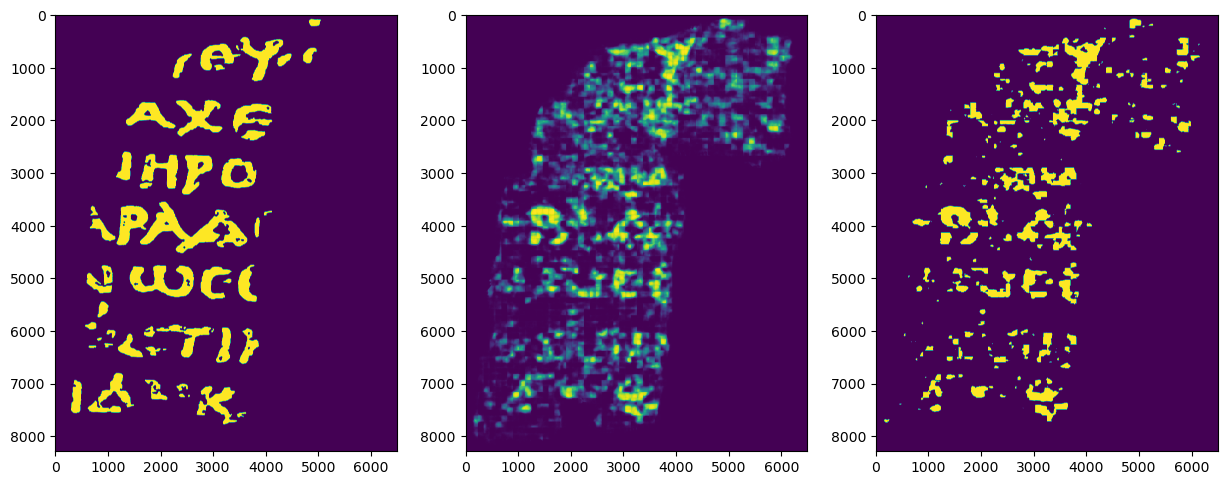

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([39233205.,  2669648.,  1805755.,  1424063.,  1150381.,   950221.,
          802568.,   722320.,   621300.,   585972.,   519510.,   466786.,
          424332.,   384917.,   350163.,   323195.,   343115.,   357429.,
          382260.,   321708.]),
 array([1.24687976e-05, 4.99673341e-02, 9.99221994e-02, 1.49877065e-01,
        1.99831930e-01, 2.49786795e-01, 2.99741661e-01, 3.49696526e-01,
        3.99651391e-01, 4.49606257e-01, 4.99561122e-01, 5.49515987e-01,
        5.99470852e-01, 6.49425718e-01, 6.99380583e-01, 7.49335448e-01,
        7.99290314e-01, 8.49245179e-01, 8.99200044e-01, 9.49154910e-01,
        9.99109775e-01]),
 <BarContainer object of 20 artists>)

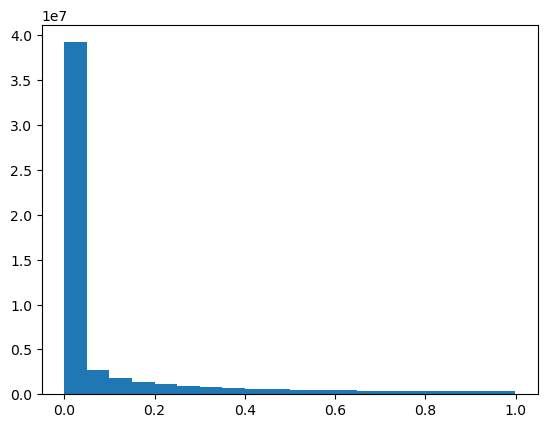

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000